In [334]:
# pip install scipy
# pip install keras

import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Dropout, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
# from keras.utils import layer_utils
# from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

from tensorflow import keras as K

K.backend.set_image_data_format('channels_last')
# K.backend.set_learning_phase(1)

In [335]:
Y_train = np.load(f'Y_train.npy')
X_train = np.load(f'X_train.npy')
Y_test = np.load(f'Y_test.npy')
X_test = np.load(f'X_test.npy')
Y_val = np.load(f'Y_val.npy')
X_val = np.load(f'X_val.npy')

In [336]:
import matplotlib.pyplot as plt

In [337]:
Y_train.shape

(12579, 32, 32)

In [338]:
X_train.shape

(12579, 32, 32, 12)

In [339]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.backend.flatten(y_true)
    y_pred_f = K.backend.flatten(y_pred)
    intersection = K.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.backend.sum(y_true_f) + K.backend.sum(y_pred_f) + smooth)

In [340]:
def res_block_maxpool(X,stage,s=1,filters=16):
    
    # name defining basis as used in ResNet assignment
    conv_name_base = 'conv' + str(stage) +  '_branch'
    pool_name_base = 'pool' + str(stage) +  '_branch'
    
    # Input value for shortcut layer
    X_shortcut = X
    
    
    # Main Path
    # Component 1 of main path
    X = Activation('relu')(X)
    X = Dropout(0.1)(X)
    
    # Component 2 of main path
    X = MaxPooling2D(pool_size = (2,2), padding='same', strides = (1,1), name = pool_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Dropout(0.1)(X)
    
    # Component 3 of main path
    X = Conv2D(filters, kernel_size=(3,3), padding='same', strides = (1,1), name = conv_name_base + '2a')(X)
    X = Dropout(0.1)(X)
    
    # Shortcut Path
    X_shortcut = Conv2D(filters, kernel_size=(3,3), padding='same', strides = (1,1), name = conv_name_base + '1')(X_shortcut)
    X_shortcut = Dropout(0.1)(X_shortcut)
    
    # Adding main path and activation
    X = Add()([X, X_shortcut])
    
    return X
    

In [341]:
def res_block_conv(X,stage,s=1,filters=32):
    
    # name defining basis as used in ResNet assignment
    conv_name_base = 'conv' + str(stage) + '_branch'
    pool_name_base = 'pool' + str(stage) + '_branch'
    
    # Input value for shortcut layer
    X_shortcut = X
    
    
    # Main Path
    # Component 1 of main path
    X = Activation('relu')(X)
    X = Dropout(0.1)(X)
    
    # Component 2 of main path
    X = Conv2D(filters, kernel_size = (2,2), padding='same', strides = (s,s), name = pool_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Dropout(0.1)(X)
    
    # Component 3 of main path
    X = Conv2D(filters, kernel_size = (3,3), padding='same', strides = (s,s), name = conv_name_base + '2a')(X)
    X = Dropout(0.1)(X)
    
    # Shortcut Path
    X_shortcut = Conv2D(filters, kernel_size = (3,3),  padding = 'same', strides = (s,s), name = conv_name_base + '1')(X_shortcut)
    X_shortcut = Dropout(0.1)(X_shortcut)
    
    # Adding main path and activation
    X = Add()([X, X_shortcut])
    
    return X

In [342]:
def ResNet(input_shape=(32,32,12), classes=2, filters=16):
    
    # Input tensor
    X_input = Input(input_shape)
    
    X = X_input
    
    
    # Stage 1
    X = Conv2D(filters, kernel_size=(3,3),padding='same', strides=(1,1), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = Dropout(0.1)(X)
    X = Conv2D(filters, kernel_size=(3,3),padding='same', strides=(1,1))(X)
    
    # Stage 2
    X = res_block_maxpool(X, stage=2, filters=16, s=1)
    
    # Stage 3
    X = res_block_maxpool(X, stage=3, filters=16, s=1)
    
    #Stage 4
    X = res_block_conv(X, stage=4, filters=32, s=1)
    
    # Stage 5
    X = res_block_conv(X, stage=5, filters=32, s=1)
    
    # Stage 6
    X = Conv2D(filters, kernel_size=(3,3),padding='same', strides=(1,1), name='conv6')(X)
    X = Activation('relu')(X)
    
    # Averagepool
    X = AveragePooling2D(pool_size=(2,2),padding='same', strides=(1,1), name='AveragePool2a')(X)
    X = Conv2D(filters=1, padding='same', kernel_size=(3,3), strides=(1,1), name='conv_last')(X)
    X = Activation('sigmoid')(X)
        
    # Create Model
    model = Model(inputs=X_input, outputs=X, name='ResNet')
    
    return model

In [343]:
model = ResNet(input_shape=(32,32,12), classes=2)

In [344]:
type(model)

keras.src.models.functional.Functional

In [345]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

In [346]:
epochs = 50

model.fit(X_train, Y_train, epochs=epochs, batch_size=32)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 59s 143ms/step - dice_coef: 0.0509 - loss: 0.0811
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 54s 138ms/step - dice_coef: 0.1090 - loss: 0.0158
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 56s 142ms/step - dice_coef: 0.0331 - loss: -0.0129
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 59s 150ms/step - dice_coef: 0.0479 - loss: -0.0180
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 53s 134ms/step - dice_coef: 0.0349 - loss: -0.0245
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 60s 154ms/step - dice_coef: 0.0438 - loss: -0.0284
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 66s 169ms/step - dice_coef: 1.4910 - loss: -0.0208
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 61s 154ms/step - dice_coef: 0.2225 - loss: -0.0262
Epoch 9/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 63s 160ms/step - dice_coef: 0.0660 - loss: -0.0193
Epoch 10/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 71s 179ms/step - dice_coef: 0.0469 - loss: -0.0267
Epoch 11/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 69s 176ms/step - dice_coef: -0.2521 - loss: -0.047

In [347]:
loss, dice_coef = model.evaluate(X_test, Y_test)

model.save(f'fire_predict_{epochs}.h5')

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - dice_coef: 0.0262 - loss: -0.0410


In [373]:
from tensorflow.keras.models import load_model

epochs = 50

model = load_model(f'fire_predict_{epochs}.h5')

In [374]:
model.summary()

Model: "ResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 32, 32,    │      1,744 │ input_layer_6[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 32, 32,    │         64 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_66       │ (None, 32, 32,    │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_102         │ (None, 32, 32,    │          0 │ activation_66[0]… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │      2,320 │ dropout_102[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_67       │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_103         │ (None, 32, 32,    │          0 │ activation_67[0]… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2_branch2a      │ (None, 32, 32,    │          0 │ dropout_103[0][0] │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_68       │ (None, 32, 32,    │          0 │ pool2_branch2a[0… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_104         │ (None, 32, 32,    │          0 │ activation_68[0]… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_branch2a      │ (None, 32, 32,    │      2,320 │ dropout_104[0][0] │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_branch1       │ (None, 32, 32,    │      2,320 │ conv2d_6[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_105         │ (None, 32, 32,    │          0 │ conv2_branch2a[0… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_106         │ (None, 32, 32,    │          0 │ conv2_branch1[0]… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 32, 32,    │          0 │ dropout_105[0][0… │
│                     │ 16)               │            │ dropout_106[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_69       │ (None, 32, 32,    │          0 │ add_24[0][0]    

 Total params: 56,771 (221.77 KB)

 Trainable params: 56,737 (221.63 KB)

 Non-trainable params: 32 (128.00 B)

 Optimizer params: 2 (12.00 B)

In [390]:
test_index = 67

In [391]:
x = X_val[test_index,:,:,:]

x = np.expand_dims(x, axis=0)

y = model.predict(x)

threshold = np.nanpercentile(y, 95)

y[y >= threshold] = 1
y[y < threshold] = 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Text(0.5, 0.98, 'Current Fire Mask #67')

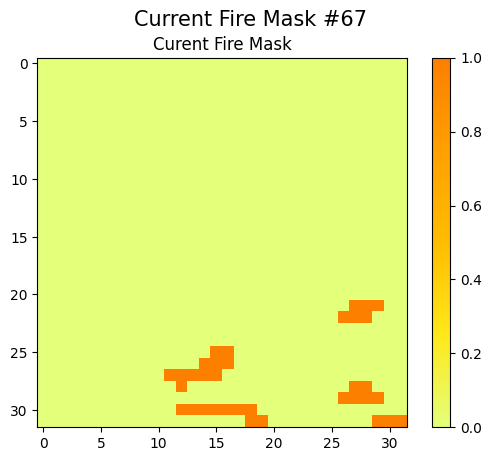

In [392]:
plt.imshow(x[0, :,:,11], cmap = 'Wistia')
plt.title('Curent Fire Mask')
plt.colorbar()
plt.clim([0,1])
plt.suptitle('Current Fire Mask #{}'.format(test_index), fontsize=15)


# plt.imshow(y[0,:,:,0], cmap = 'Wistia')
# plt.title('Predicted Fire Mask')
# plt.colorbar()
# plt.clim([0,1])
# plt.suptitle('Previous Day Mask, True Mask v/s Prediction (Training Data) #{}'.format(test_index), fontsize=15)

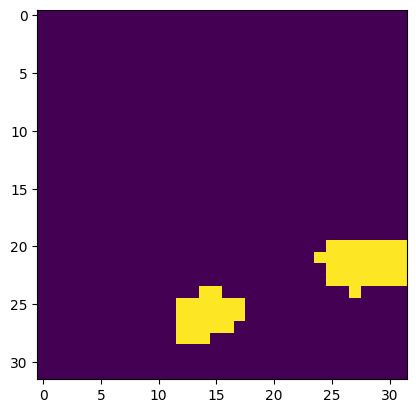

In [393]:


plt.imshow(y[0,:,:,0])



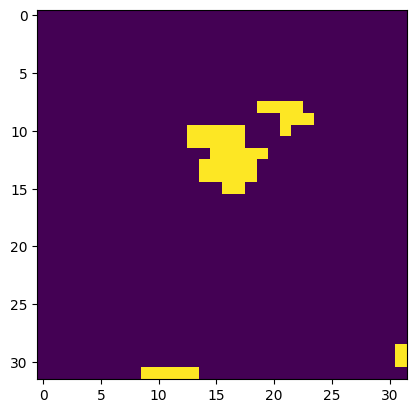

In [394]:
plt.imshow(Y_val[test_index,:,:])